![Random Unsplash Image](https://i.ytimg.com/vi/X4ZdLBVMPyI/maxresdefault.jpg)

# features descriptions 

<ol>
 <li>id - a unique identifier for each tweet</li>
 <li>text - the text of the tweet</li>
 <li>location - the location the tweet was sent from</li>
  <li>keyword - a particular keyword from the tweet</li>
  <li> target -whether a tweet is about a real disaster (1) or not (0)</li>
</ol>

In [0]:
!pip install gensim
!pip install wordcloud
!pip install tensorflow
!pip install pydot

In [0]:
import re
import string 
import numpy as np

## Visualization tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import gensim
from wordcloud import WordCloud, STOPWORDS
import warnings


from nltk.tokenize import sent_tokenize, word_tokenize

  
warnings.filterwarnings(action = 'ignore')


## Import Logistic Regression function for model training from linear model module of sklearn package
from sklearn.linear_model import LogisticRegression

## Import functions for evaluation from  model selection module of sklearn package
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,precision_score,roc_auc_score,roc_curve

## Import functions for model selection from model selection module of sklearn package
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

## Import functions for text vectorization from feature extraction module of sklearn package
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Import function from NLTK package for Text tokenization and Normalization
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec

### tensorflow
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from keras.regularizers import L1L2
from keras.layers import Flatten
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.optimizers as O
import tensorflow.keras.losses as Los
from tensorflow.keras.utils import plot_model

# Import data

In [0]:
Data= pd.read_csv("/dbfs/FileStore/tables/WarrenLata_Breezometer/train.csv")

In [0]:
Data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


#Let's make some visualisations and explorations

In [0]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 id 7613 non-null int64 
 1 keyword 7552 non-null object
 2 location 5080 non-null object
 3 text 7613 non-null object
 4 target 7613 non-null int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

We can see the data has Nan values especially in fields keyword and location. Let's see what is inside the field Keyword

In [0]:
Data=Data[['keyword','text','target']]

In [0]:
Data

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,NaN,Two giant cranes holding a bridge collapse int...,1
7609,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,NaN,Police investigating after an e-bike collided ...,1


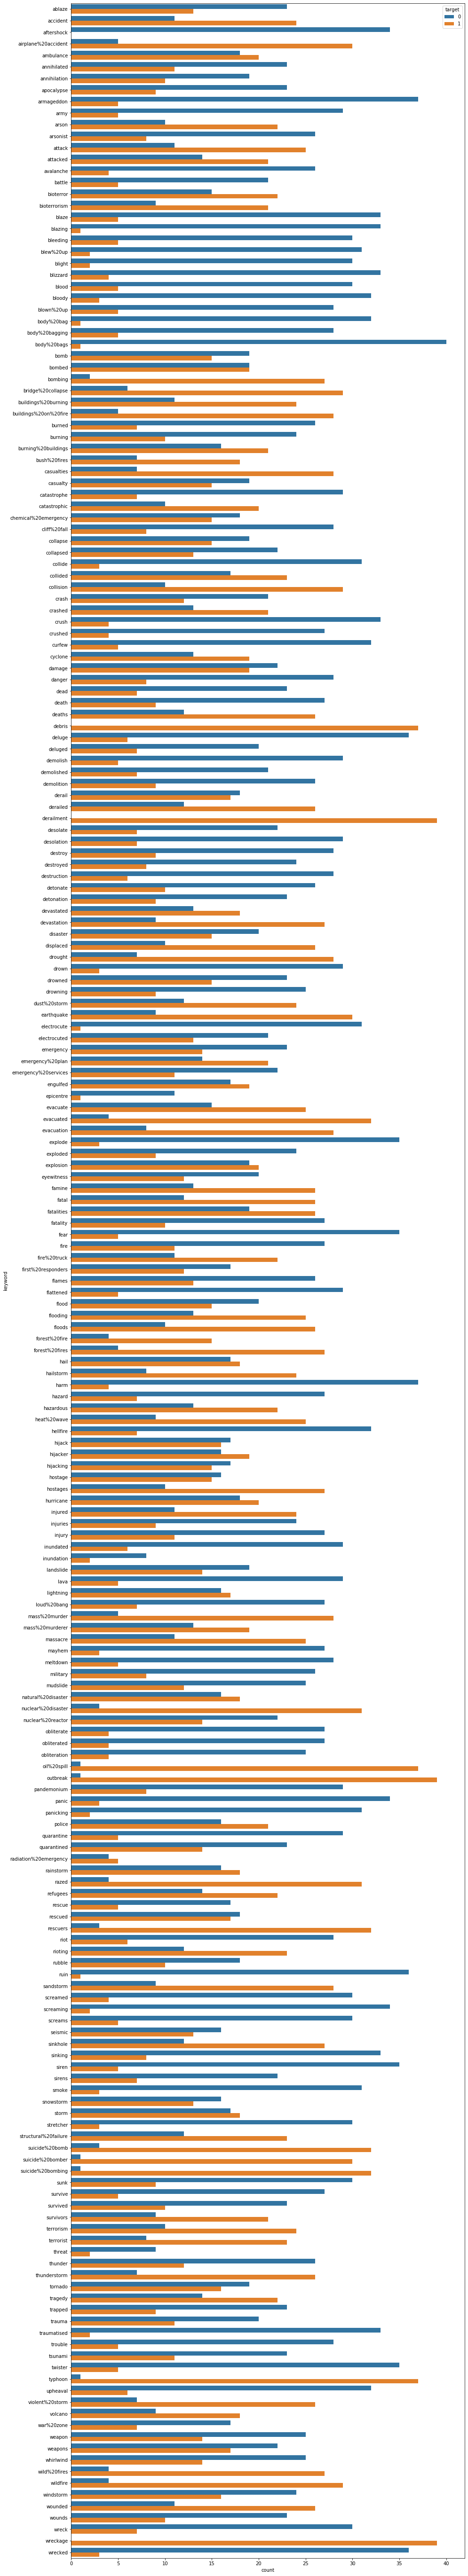

In [0]:
plt.figure(figsize=(15,100))
sns.countplot(data=Data, y='keyword' , hue='target')

All Keywords have a link with bad events and we can see that they are affected to every text without taking into account the class of the text (disaster or not)

### let's clean the data

In [0]:
Data=Data[['text','target']]

In [0]:
stop_words = stopwords.words('english')
### Stemming of Porter
stemmer = PorterStemmer()

## we shall lower every char
def lower_text(text):
    text = text.lower() # lowering
    return text
    
## We shall remove newlines,punctuations, links,stopwords,espcape etc
def remove_newline(text):
    text = re.sub(r'\n',' ', text)
    return text

def remove_punctuations(text): 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text


def remove_links(text):   
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    
    return text

def remove_tags(text):   
    text = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|(\w+:\/\/\S+)","",text)
    return text
    
def remove_multiplespaces(text):   
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

def remove_specialchars(text):   
    text = re.sub(r'\W', ' ', text)
    return text

def remove_stopwords(text):   
    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    return text

def word_stemming(text):       
    text=' '.join([stemmer.stem(word) for word in word_tokenize(text)])
    return text

In [0]:
#####
# Covert text to lowercase
Data.text=Data.text.apply(lambda text: lower_text(text))

# Remove newlines
Data.text=Data.text.apply(lambda text: remove_newline(text))

# Remove punctuations
Data.text=Data.text.apply(lambda text: remove_punctuations(text))

# Remove links
Data.text=Data.text.apply(lambda text: remove_links(text))

# Remove tags
Data.text=Data.text.apply(lambda text: remove_tags(text))

# Remove multiple spaces
Data.text=Data.text.apply(lambda text: remove_multiplespaces(text))

# Remove special characters
Data.text=Data.text.apply(lambda text: remove_specialchars(text))

# Remove stopwords
Data.text=Data.text.apply(lambda text: remove_stopwords(text))

# Apply Stemming
Data.text=Data.text.apply(lambda text: word_stemming(text))

In [0]:
Data

,text,target
0,deed reason earthquak may allah forgiv us,1
1,forest fire near la rong sask canada,1
2,resid ask shelter place notifi offic evacu she...,1
3,13000 peopl receiv wildfir evacu order california,1
4,got sent photo rubi alaska smoke wildfir pour ...,1
...,...,...
7608,two giant crane hold bridg collaps nearbi home...,1
7609,ariaahrari thetawniest control wild fire calif...,1
7610,m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj,1
7611,polic investig ebik collid car littl portug eb...,1


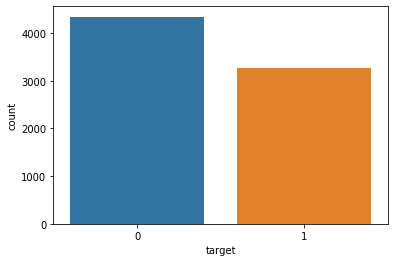

In [0]:
sns.countplot(Data.target)

In [0]:
print(f'{Data.target[Data.target==1].count()/Data.target.count()*100:.2f} % of tweets are labeled as disaster tweets in data')

42.97 % of tweets are labeled as disaster tweets in data

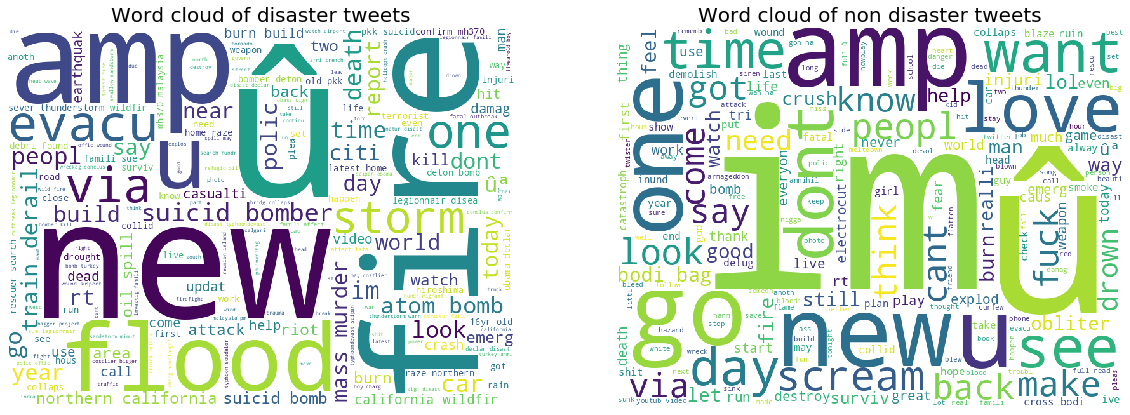

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 12))

wc_disaster = WordCloud(
        width=800, height=600,
        background_color='white',
        stopwords=STOPWORDS
    ).generate(' '.join(Data[Data.target==1]['text']))

wc_nondisaster = WordCloud(
        width=800, height=600,
        background_color='white',
        stopwords=STOPWORDS
    ).generate(' '.join(Data[Data.target==0]['text']))

ax1.imshow(wc_disaster)
ax1.set_title("Word cloud of disaster tweets", fontsize=20)
ax1.axis("off")

ax2.imshow(wc_nondisaster)
ax2.set_title("Word cloud of non disaster tweets", fontsize=20)
ax2.axis("off")

fig.show()

# Vectorization

The field Text is not yet ready to be used. We will be using bag of word to convert this field so we can train a model

In [0]:
train, test = train_test_split(Data,test_size=0.25,random_state=0)

In [0]:
# Bag-of-words
count_vectorizer = CountVectorizer()
train_vectors_bow = count_vectorizer.fit_transform(train["text"])
test_vectors_bow = count_vectorizer.transform(test["text"])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
train_vectors_tf = tfidf_vectorizer.fit_transform(train["text"])
test_vectors_tf = tfidf_vectorizer.transform(test["text"])

## The models

In [0]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(1, activation='sigmoid', input_dim=train_vectors_tf.shape[1]))
    model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [0]:
model=build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
dense_2 (Dense) (None, 1) 15813 
=================================================================
Total params: 15,813
Trainable params: 15,813
Non-trainable params: 0
_________________________________________________________________

In [0]:
BATCH_SIZE = 40
EPOCHS =10
history = model.fit(train_vectors_bow.toarray(),
                        train["target"],
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE)

Epoch 1/10
 1/143 [..............................] - ETA: 42s - loss: 0.6983 - accuracy: 0.5250 26/143 [====>.........................] - ETA: 0s - loss: 0.6892 - accuracy: 0.5760  53/143 [==========>...................] - ETA: 0s - loss: 0.6844 - accuracy: 0.6340 80/143 [===============>..............] - ETA: 0s - loss: 0.6795 - accuracy: 0.6678107/143 [=====================>........] - ETA: 0s - loss: 0.6747 - accuracy: 0.6864135/143 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.7017143/143 [==============================] - 1s 2ms/step - loss: 0.6685 - accuracy: 0.7029
Epoch 2/10
 1/143 [..............................] - ETA: 0s - loss: 0.6307 - accuracy: 0.8750 28/143 [====>.........................] - ETA: 0s - loss: 0.6213 - accuracy: 0.8286 56/143 [==========>...................] - ETA: 0s - loss: 0.6175 - accuracy: 0.8259 81/143 [===============>..............] - ETA: 0s - loss: 0.6153 - accuracy: 0.8231108/143 [=====================>........] - ETA: 0s - loss: 0.6114 - accuracy: 0.8213136/143 [===========================>..] - ETA: 0s - loss: 0.6083 - accuracy: 0.8184143/143 [==============================] - 0s 2ms/step - loss: 0.6077 - accuracy: 0.8185
Epoch 3/10
 1/143 [..............................] - ETA: 0s - loss: 0.5455 - accuracy: 0.8750 27/143 [====>.........................] - ETA: 0s - loss: 0.5711 - accuracy: 0.8463 55/143 [==========>...................] - ETA: 0s - loss: 0.5691 - accuracy: 0.8418 84/143 [================>.............] - ETA: 0s - loss: 0.5651 - accuracy: 0.8420112/143 [======================>.......] - ETA: 0s - loss: 0.5621 - accuracy: 0.8408141/143 [============================>.] - ETA: 0s - loss: 0.5589 - accuracy: 0.8410143/143 [==============================] - 0s 2ms/step - loss: 0.5586 - accuracy: 0.8406
Epoch 4/10
 1/143 [..............................] - ETA: 0s - loss: 0.5371 - accuracy: 0.8000 29/143 [=====>........................] - ETA: 0s - loss: 0.5271 - accuracy: 0.8483 57/143 [==========>...................] - ETA: 0s - loss: 0.5258 - accuracy: 0.8509 86/143 [=================>............] - ETA: 0s - loss: 0.5234 - accuracy: 0.8529

In [0]:
prediction=model.predict(test_vectors_bow.toarray())
y_predicted = np.where(prediction>0.5,1,0)

In [0]:
tn, fp, fn, tp = confusion_matrix(test['target'],y_predicted).ravel()
tot = confusion_matrix(test['target'],y_predicted).sum()

print("We have %.1f%% accuracy on the test dataset" % (float(accuracy_score(test['target'],y_predicted))*100))
print("We have %.1f%% recall on the test dataset" % (float(recall_score(test['target'],y_predicted))*100))
print("We have %.1f%% precision on the test dataset" % (float(precision_score(test['target'],y_predicted))*100))
print("We have %.1f%% ROC AUC on the test dataset" % (float(roc_auc_score(test['target'],model.predict_proba(test_vectors_bow.toarray())))*100))

We have 81.2% accuracy on the test dataset
We have 65.7% recall on the test dataset
We have 86.0% precision on the test dataset
We have 86.1% ROC AUC on the test dataset

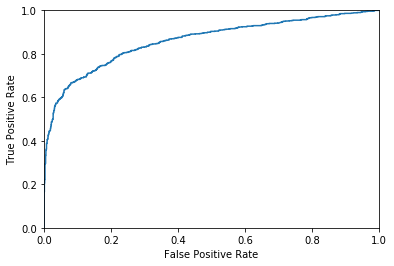

In [0]:
fpr , tpr , thresholds = roc_curve (test['target'],model.predict_proba(test_vectors_bow.toarray()))

def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 

The higher the true positive (TPR), the more false positives (FPR) the classifier produces